In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [2]:
import sys
sys.path.append('..')

In [3]:
import mysecrets
import config
import fetch_from_cluster
import catalogmanager

/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
s2_satellite_catalog_gdf = \
fetch_from_cluster.load_satellite_sentinel2_catalog(
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
    # overwrite = True,
)

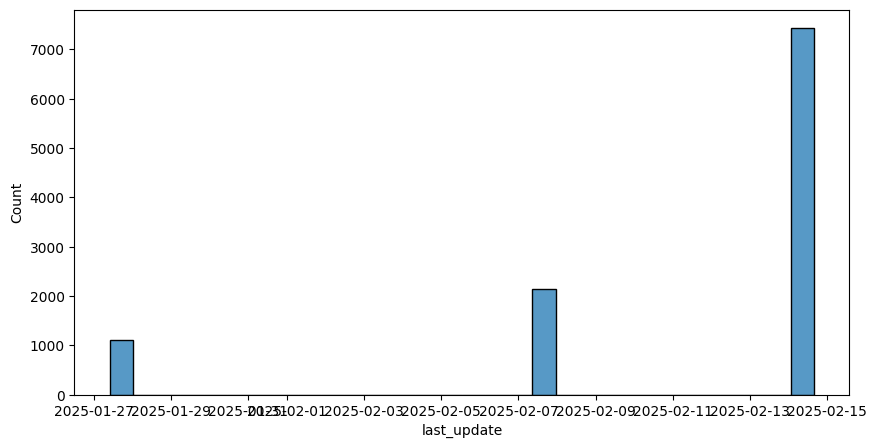

In [5]:
scale = 5
aspect_ratio = 2
fig, ax = plt.subplots(figsize=(scale*aspect_ratio, scale))

g = sns.histplot(
    data = s2_satellite_catalog_gdf[
        s2_satellite_catalog_gdf['last_update'] >= catalogmanager.dt2ts(dt=datetime.datetime(2025, 1, 1))
    ],
    x = 'last_update',
)

In [6]:
s2l2a_catalog_gdf = s2_satellite_catalog_gdf[
    s2_satellite_catalog_gdf['satellite'] == 'sentinel-2-l2a'
]

In [7]:
s2l2a_catalog_gdf[s2l2a_catalog_gdf['files'].apply(lambda x: 'B01.jp2' not in x)]['s3url'].tolist()[0]

's3://EODATA/Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE'

In [8]:
import cdseutils.sentinel2

In [9]:
cdseutils.sentinel2.get_s3paths_single_url(
    s3url = 's3://EODATA/Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE',
    s3_creds = cdseutils.utils.cdse_credentials_from_json('../data/cdse_credentials.json').s3_creds,
    satellite = cdseutils.constants.Bands.S2L2A.NAME,
    root_folderpath = './',
    bands = cdseutils.constants.Bands.S2L2A.ALL,
)

S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R20m/T37PDK_20220103T074321_SCL_20m.jp2')
S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R20m/T37PDK_20220103T074321_B06_20m.jp2')
S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R10m/T37PDK_20220103T074321_B03_10m.jp2')
S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/MTD_TL.xml')
S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A03

([S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R20m/T37PDK_20220103T074321_SCL_20m.jp2'),
  S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R20m/T37PDK_20220103T074321_B06_20m.jp2'),
  S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/IMG_DATA/R10m/T37PDK_20220103T074321_B03_10m.jp2'),
  S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/L2A_T37PDK_A034123_20220103T074320/MTD_TL.xml'),
  S3Path(bucket='EODATA', prefix='Sentinel-2/MSI/L2A/2022/01/03/S2A_MSIL2A_20220103T074321_N0301_R092_T37PDK_20220103T104053.SAFE/GRANULE/

In [ ]:
[1,2,3][-2:]

In [ ]:
s2_satellite_catalog_gdf.shape

In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [ ]:
satellite_filepaths = fetch_from_cluster.download_sentinel2_satellite(
    id = selected_id,
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
)

In [ ]:
satellite_filepaths